# Hybrid Model

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm

In [ ]:
# ================= CONFIGURATION =================
CONFIG = {
    'img_size': 224,
    'batch_size': 32,
    'epochs': 20,
    'lr': 1e-4,
    'num_classes': 4, # CHANGED: 4 Clinical Stages
    'seed': 42,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'checkpoint_dir': './checkpoints_hybrid_4class'
}
os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)

In [ ]:
# ================= DATASET (Dual Targets) =================
def apply_clahe(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(image)
    return cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

class HybridDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['id']}.png")
        image = cv2.imread(img_path)
        if image is None: image = np.zeros((224, 224, 3), dtype=np.uint8)
        
        image = apply_clahe(image)
        if self.transform:
            image = self.transform(image=image)['image']

        gender = torch.tensor(1.0 if row['male'] else 0.0, dtype=torch.float32)
        
        # Target 1: Regression (Months)
        target_reg = torch.tensor(row['boneage'], dtype=torch.float32)
        
        # Target 2: Classification (4 Classes)
        months = row['boneage']
        if months <= 60: label = 0
        elif months <= 120: label = 1
        elif months <= 180: label = 2
        else: label = 3
        target_cls = torch.tensor(label, dtype=torch.long)
        
        return image, gender, target_reg, target_cls

def get_transforms(split):
    if split == 'train':
        return A.Compose([
            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    return A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

In [ ]:
# ================= HYBRID MODEL =================
class BoneAgeHybrid(nn.Module):
    def __init__(self, num_classes):
        super(BoneAgeHybrid, self).__init__()
        # [cite_start]Backbone: ResNet152 [cite: 29]
        self.backbone = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.gender_fc = nn.Linear(1, 32)
        self.fc_common = nn.Linear(num_ftrs + 32, 512)
        self.relu = nn.ReLU()
        
        # Head 1: Regression
        self.regressor = nn.Linear(512, 1)
        
        # Head 2: Classification (4 Classes)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x, gender):
        feat = self.backbone(x)
        gender_feat = self.gender_fc(gender.unsqueeze(1))
        combined = torch.cat((feat, gender_feat), dim=1)
        x = self.relu(self.fc_common(combined))
        
        return self.regressor(x), self.classifier(x)

In [ ]:
# ================= TRAINING LOOP =================
def run_hybrid_training():
    base_dir = '/kaggle/input/rsna-bone-age'
    df = pd.read_csv(f'{base_dir}/boneage-training-dataset.csv')
    img_dir = f'{base_dir}/boneage-training-dataset/boneage-training-dataset'
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=CONFIG['seed'])
    
    dataloaders = {
        'train': DataLoader(HybridDataset(train_df, img_dir, get_transforms('train')), batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2),
        'val': DataLoader(HybridDataset(val_df, img_dir, get_transforms('val')), batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)
    }

    model = BoneAgeHybrid(num_classes=CONFIG['num_classes']).to(CONFIG['device'])
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True) # Monitor MAE
    
    criterion_reg = nn.L1Loss()
    criterion_cls = nn.CrossEntropyLoss()

    best_mae = float('inf')

    print("Starting Hybrid 4-Class Training...")
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        
        for imgs, genders, t_reg, t_cls in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}"):
            imgs, genders = imgs.to(CONFIG['device']), genders.to(CONFIG['device'])
            t_reg, t_cls = t_reg.to(CONFIG['device']), t_cls.to(CONFIG['device'])
            
            optimizer.zero_grad()
            p_reg, p_cls = model(imgs, genders)
            
            # Combined Loss
            loss_r = criterion_reg(p_reg.squeeze(), t_reg)
            loss_c = criterion_cls(p_cls, t_cls)
            loss = loss_r + loss_c # 1:1 weighting
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_mae_sum = 0
        val_acc_sum = 0
        total = 0
        
        with torch.no_grad():
            for imgs, genders, t_reg, t_cls in dataloaders['val']:
                imgs, genders = imgs.to(CONFIG['device']), genders.to(CONFIG['device'])
                t_reg, t_cls = t_reg.to(CONFIG['device']), t_cls.to(CONFIG['device'])
                
                p_reg, p_cls = model(imgs, genders)
                
                # Metrics
                val_mae_sum += torch.abs(p_reg.squeeze() - t_reg).sum().item()
                _, p_cls_labels = torch.max(p_cls, 1)
                val_acc_sum += (p_cls_labels == t_cls).sum().item()
                total += t_reg.size(0)
        
        epoch_mae = val_mae_sum / total
        epoch_acc = val_acc_sum / total
        
        print(f"Epoch {epoch+1} | Val MAE: {epoch_mae:.2f}m | Val Acc: {epoch_acc:.2%}")
        
        scheduler.step(epoch_mae)
        if epoch_mae < best_mae:
            best_mae = epoch_mae
            torch.save(model.state_dict(), f"{CONFIG['checkpoint_dir']}/best_hybrid_4class.pth")

run_hybrid_training()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_absolute_error, r2_score

def run_hybrid_testing():
    print("\n" + "="*50)
    print("🚀 FINAL EVALUATION: HYBRID MODEL (4-CLASS + REG)")
    print("="*50)

    # 1. SETUP
    base_dir = '/kaggle/input/rsna-bone-age'
    df = pd.read_csv(f'{base_dir}/boneage-training-dataset.csv')
    img_dir = f'{base_dir}/boneage-training-dataset/boneage-training-dataset'
    
    # Re-split
    _, val_df = train_test_split(df, test_size=0.2, random_state=CONFIG['seed'])
    _, test_df = train_test_split(val_df, test_size=0.5, random_state=CONFIG['seed'])
    
    test_ds = HybridDataset(test_df, img_dir, transform=get_transforms('val'))
    test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

    # 2. LOAD MODEL
    model = BoneAgeHybrid(num_classes=4).to(CONFIG['device'])
    checkpoint_path = f"{CONFIG['checkpoint_dir']}/best_hybrid_4class.pth"
    
    if not os.path.exists(checkpoint_path):
        print("❌ Checkpoint not found.")
        return

    # Load Weights
    state_dict = torch.load(checkpoint_path)
    if 'module.' in list(state_dict.keys())[0]:
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            new_state_dict[k.replace('module.', '')] = v
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(state_dict)

    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)

    # 3. INFERENCE
    model.eval()
    t_reg_list, p_reg_list = [], []
    t_cls_list, p_cls_list = [], []
    
    print("Processing Test Set...")
    with torch.no_grad():
        for imgs, genders, t_reg, t_cls in tqdm(test_loader):
            imgs, genders = imgs.to(CONFIG['device']), genders.to(CONFIG['device'])
            
            p_reg, p_cls = model(imgs, genders)
            _, p_cls_labels = torch.max(p_cls, 1)
            
            # Regression data
            t_reg_list.extend(t_reg.numpy())
            p_reg_list.extend(p_reg.cpu().squeeze().numpy())
            
            # Classification data
            t_cls_list.extend(t_cls.numpy())
            p_cls_list.extend(p_cls_labels.cpu().numpy())

    # 4. REPORT
    mae = mean_absolute_error(t_reg_list, p_reg_list)
    r2 = r2_score(t_reg_list, p_reg_list)
    acc = accuracy_score(t_cls_list, p_cls_list)
    
    print("\n" + "-"*40)
    print("📊 HYBRID RESULTS")
    print("-" * 40)
    print(f"Regression MAE: {mae:.4f} months (Paper Goal: 2.59)")
    print(f"Regression R2:  {r2:.4f}")
    print(f"Class Accuracy: {acc:.4f}")
    
    print("\nClassification Report (Stages):")
    class_names = ['0-5 Yrs', '5-10 Yrs', '10-15 Yrs', '15+ Yrs']
    print(classification_report(t_cls_list, p_cls_list, target_names=class_names))
    
    # 5. VISUALIZATION
    cm = confusion_matrix(t_cls_list, p_cls_list)
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Confusion Matrix
    plt.subplot(1, 2, 1)
    

    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
    plt.title('Stage Classification')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Plot 2: Regression Scatter
    plt.subplot(1, 2, 2)
    plt.scatter(t_reg_list, p_reg_list, alpha=0.3, s=10, c='blue')
    plt.plot([0, 240], [0, 240], 'r--')
    plt.title(f'Age Regression (MAE: {mae:.2f})')
    plt.xlabel('Actual Months')
    plt.ylabel('Predicted Months')
    
    plt.tight_layout()
    plt.show()

run_hybrid_testing()

# Separate Models

In [22]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm

In [23]:
# ================= CONFIGURATION =================
CONFIG = {
    'img_size': 224,
    'batch_size': 32,
    'epochs': 20,
    'lr': 1e-4,
    'seed': 42,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'checkpoint_dir': './checkpoints_regression'
}
os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)

In [24]:
# ================= PREPROCESSING & DATASET =================
def apply_clahe(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(image)
    return cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

class RegressionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['id']}.png")
        image = cv2.imread(img_path)
        if image is None: image = np.zeros((224, 224, 3), dtype=np.uint8)
        
        image = apply_clahe(image)
        if self.transform:
            image = self.transform(image=image)['image']

        gender = torch.tensor(1.0 if row['male'] else 0.0, dtype=torch.float32)
        target = torch.tensor(row['boneage'], dtype=torch.float32) # Months
        return image, gender, target

def get_transforms(split):
    if split == 'train':
        return A.Compose([
            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    return A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

In [25]:
# ================= MODEL (REGRESSION ONLY) =================
class BoneAgeRegressor(nn.Module):
    def __init__(self):
        super(BoneAgeRegressor, self).__init__()
        self.backbone = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.gender_fc = nn.Linear(1, 32)
        self.fc_common = nn.Linear(num_ftrs + 32, 512)
        self.relu = nn.ReLU()
        self.regressor = nn.Linear(512, 1) # Single output for Months

    def forward(self, x, gender):
        feat = self.backbone(x)
        gender_feat = self.gender_fc(gender.unsqueeze(1))
        combined = torch.cat((feat, gender_feat), dim=1)
        x = self.relu(self.fc_common(combined))
        return self.regressor(x)

In [26]:
# ================= TRAINING LOOP =================
def run_regression_training():
    base_dir = '/kaggle/input/rsna-bone-age'
    df = pd.read_csv(f'{base_dir}/boneage-training-dataset.csv')
    img_dir = f'{base_dir}/boneage-training-dataset/boneage-training-dataset'
    
    train_df, val_test_df = train_test_split(df, test_size=0.3, random_state=CONFIG['seed'])
    test_df, val_df = train_test_split(df, test_size=0.5, random_state=CONFIG['seed'])
    
    dataloaders = {
        'train': DataLoader(RegressionDataset(train_df, img_dir, get_transforms('train')), batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2),
        'val': DataLoader(RegressionDataset(val_df, img_dir, get_transforms('val')), batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)
    }

    model = BoneAgeRegressor().to(CONFIG['device'])
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
    criterion = nn.L1Loss()

    best_mae = float('inf')

    print("Starting Regression Training...")
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        
        for imgs, genders, targets in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}"):
            imgs, genders, targets = imgs.to(CONFIG['device']), genders.to(CONFIG['device']), targets.to(CONFIG['device'])
            
            optimizer.zero_grad()
            preds = model(imgs, genders).squeeze()
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for imgs, genders, targets in dataloaders['val']:
                imgs, genders = imgs.to(CONFIG['device']), genders.to(CONFIG['device'])
                preds = model(imgs, genders).squeeze()
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(targets.numpy())
        
        mae = mean_absolute_error(val_targets, val_preds)
        rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
        r2 = r2_score(val_targets, val_preds)
        
        print(f"Epoch {epoch+1} | Val MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f}")
        
        scheduler.step(mae)
        if mae < best_mae:
            best_mae = mae
            torch.save(model.state_dict(), f"{CONFIG['checkpoint_dir']}/best_regression_model.pth")

run_regression_training()

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Starting Regression Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 1 | Val MAE: 21.5703 | RMSE: 26.2999 | R2: 0.6095


Epoch 2:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 2 | Val MAE: 11.2321 | RMSE: 14.5069 | R2: 0.8812


Epoch 3:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 3 | Val MAE: 13.2908 | RMSE: 16.7611 | R2: 0.8414


Epoch 4:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 4 | Val MAE: 9.9572 | RMSE: 13.1689 | R2: 0.9021


Epoch 5:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 5 | Val MAE: 9.5727 | RMSE: 12.1120 | R2: 0.9172


Epoch 6:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 6 | Val MAE: 9.9120 | RMSE: 12.8243 | R2: 0.9071


Epoch 7:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 7 | Val MAE: 8.9491 | RMSE: 11.9717 | R2: 0.9191


Epoch 8:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 8 | Val MAE: 8.5285 | RMSE: 11.2180 | R2: 0.9290


Epoch 9:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 9 | Val MAE: 8.2854 | RMSE: 10.9894 | R2: 0.9318


Epoch 10:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 10 | Val MAE: 8.3120 | RMSE: 11.1023 | R2: 0.9304


Epoch 11:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 11 | Val MAE: 9.8984 | RMSE: 12.5386 | R2: 0.9112


Epoch 12:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 12 | Val MAE: 8.5926 | RMSE: 11.0410 | R2: 0.9312


Epoch 13:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 13 | Val MAE: 10.8795 | RMSE: 13.6578 | R2: 0.8947


Epoch 14:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 14 | Val MAE: 7.7741 | RMSE: 10.3506 | R2: 0.9395


Epoch 15:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 15 | Val MAE: 7.8251 | RMSE: 10.3456 | R2: 0.9396


Epoch 16:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 16 | Val MAE: 7.9476 | RMSE: 10.4746 | R2: 0.9381


Epoch 17:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 17 | Val MAE: 7.7819 | RMSE: 10.3229 | R2: 0.9398


Epoch 18:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 18 | Val MAE: 7.9103 | RMSE: 10.4026 | R2: 0.9389


Epoch 19:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 19 | Val MAE: 7.8483 | RMSE: 10.3444 | R2: 0.9396


Epoch 20:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 20 | Val MAE: 7.8382 | RMSE: 10.3110 | R2: 0.9400



🚀 STARTING FINAL EVALUATION (REGRESSION MODEL)
Test Set Size: 1892 images
Running Inference on Test Set...


  0%|          | 0/60 [00:00<?, ?it/s]


----------------------------------------
📊 FINAL RESULTS SUMMARY
----------------------------------------
METRIC                    | VALUE     
------------------------------------------------------------
MAE (Months)              | 6.7288
RMSE (Months)             | 9.1914
R2 Score                  | 0.9506
------------------------------------------------------------


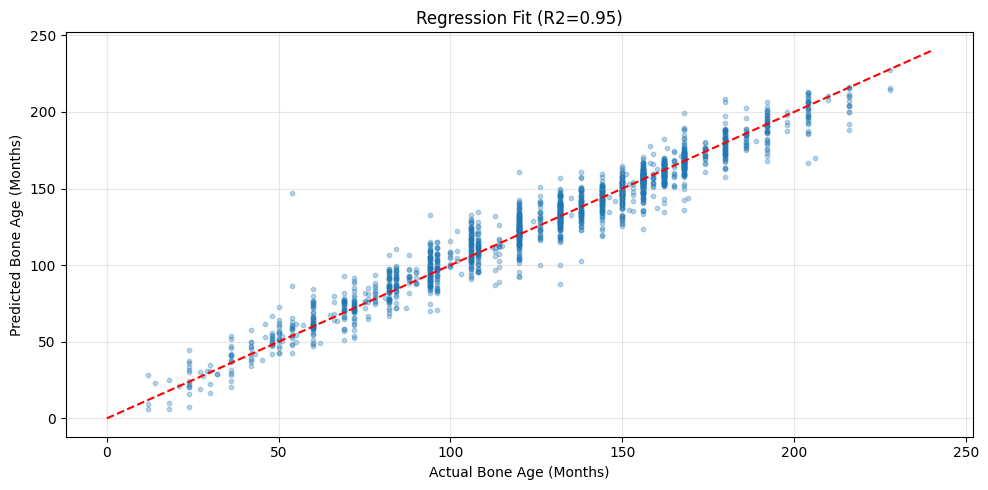

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score, classification_report

# ==========================================
# 🧪 FINAL EVALUATION: REGRESSION MODEL
# ==========================================
def run_regression_testing():
    print("\n" + "="*50)
    print("🚀 STARTING FINAL EVALUATION (REGRESSION MODEL)")
    print("="*50)

    # 1. RECREATE DATA SPLIT (To get the unseen Test Set)
    base_dir = '/kaggle/input/rsna-bone-age'
    df = pd.read_csv(f'{base_dir}/boneage-training-dataset.csv')
    img_dir = f'{base_dir}/boneage-training-dataset/boneage-training-dataset'
    
    # Use exact same seed as training to ensure 'test_df' is actually unseen data
    train_df, val_df = train_test_split(df, test_size=0.3, random_state=CONFIG['seed'])
    val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=CONFIG['seed'])
    
    print(f"Test Set Size: {len(test_df)} images")

    # 2. SETUP DATALOADER
    test_ds = RegressionDataset(test_df, img_dir, transform=get_transforms('val'))
    test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

    # 3. LOAD BEST MODEL
    model = BoneAgeRegressor().to(CONFIG['device'])
    
    checkpoint_path = f"checkpoints_regression/best_regression_model.pth"
    if not os.path.exists(checkpoint_path):
        print(f"❌ Error: Checkpoint not found at {checkpoint_path}")
        return

    # Load weights (Handling DataParallel 'module.' prefix if it exists)
    state_dict = torch.load(checkpoint_path)
    if 'module.' in list(state_dict.keys())[0]:
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k.replace('module.', '')
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(state_dict)

    # Re-wrap in DataParallel if multiple GPUs are available
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        
    # 4. INFERENCE LOOP
    model.eval()
    true_months = []
    pred_months = []
    
    print("Running Inference on Test Set...")
    with torch.no_grad():
        for imgs, genders, targets in tqdm(test_loader):
            imgs = imgs.to(CONFIG['device'])
            genders = genders.to(CONFIG['device'])
            
            # Predict
            preds = model(imgs, genders).squeeze()
            
            # Collect results
            true_months.extend(targets.numpy())
            pred_months.extend(preds.cpu().numpy())

    true_months = np.array(true_months)
    pred_months = np.array(pred_months)

    # ==========================================
    # 5. METRIC CALCULATION
    # ==========================================
    
    # --- A. Regression Metrics (The Standard) ---
    mae = mean_absolute_error(true_months, pred_months)
    rmse = np.sqrt(mean_squared_error(true_months, pred_months))
    r2 = r2_score(true_months, pred_months)

    # ==========================================
    # 6. REPORTING
    # ==========================================
    print("\n" + "-"*40)
    print("📊 FINAL RESULTS SUMMARY")
    print("-" * 40)
    print(f"{'METRIC':<25} | {'VALUE':<10}")
    print("-" * 60)
    print(f"{'MAE (Months)':<25} | {mae:.4f}")
    print(f"{'RMSE (Months)':<25} | {rmse:.4f}")
    print(f"{'R2 Score':<25} | {r2:.4f}")
    print("-" * 60)

    # ==========================================
    # 7. VISUALIZATION
    # ==========================================
    
    # Plot 1: Actual vs Predicted Scatter Plot
    plt.figure(figsize=(10, 5))
    plt.scatter(true_months, pred_months, alpha=0.3, s=10)
    plt.plot([0, 240], [0, 240], color='red', linestyle='--') # Perfect prediction line
    plt.xlabel('Actual Bone Age (Months)')
    plt.ylabel('Predicted Bone Age (Months)')
    plt.title(f'Regression Fit (R2={r2:.2f})')
    plt.grid(True, alpha=0.3)
    

    plt.tight_layout()
    plt.show()

# Run the evaluation
run_regression_testing()


🚀 STARTING FINAL GENDER-WISE EVALUATION
Test Set Size: 1892 images
Running Inference on Test Set...


  0%|          | 0/60 [00:00<?, ?it/s]


-----------------------------------------------------------------
📊 FINAL GENDER-WISE RESULTS
-----------------------------------------------------------------
METRIC          | OVERALL      | MALE (Boys)  | FEMALE (Girls)
-----------------------------------------------------------------
MAE (Months)    | 6.7288       | 6.4122       | 7.1039
RMSE            | 9.1914       | 9.1738       | 9.2122
R2 Score        | 0.9506       | 0.9513       | 0.9421
-----------------------------------------------------------------
Sample Count    | 1892         | 1026         | 866         
-----------------------------------------------------------------


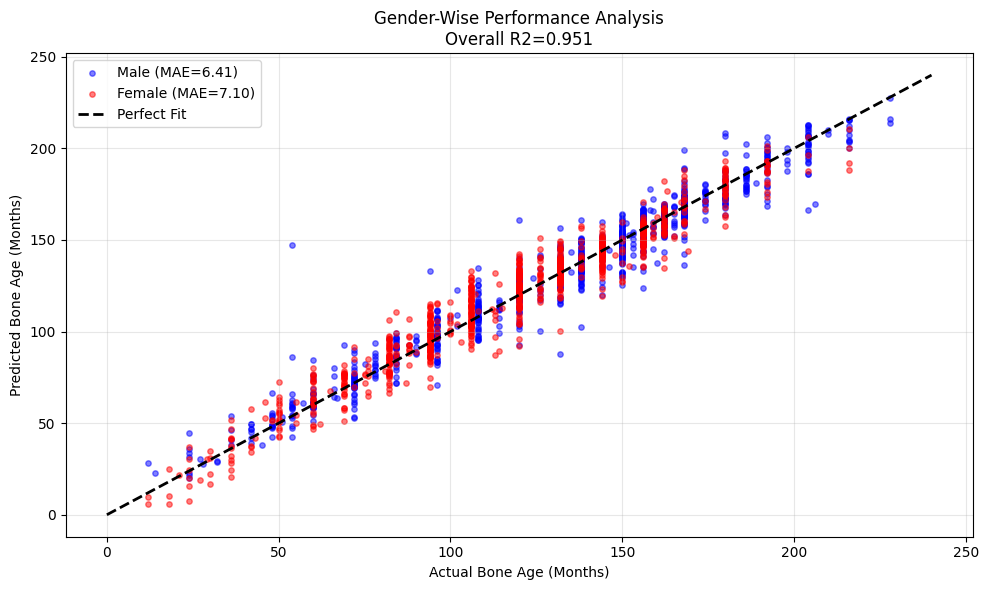

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm.auto import tqdm
import os

# ==========================================
# 🧪 FINAL EVALUATION: REGRESSION MODEL (GENDER-WISE)
# ==========================================
def run_regression_testing_gender_wise():
    print("\n" + "="*50)
    print("🚀 STARTING FINAL GENDER-WISE EVALUATION")
    print("="*50)

    # 1. RECREATE DATA SPLIT
    base_dir = '/kaggle/input/rsna-bone-age'
    df = pd.read_csv(f'{base_dir}/boneage-training-dataset.csv')
    img_dir = f'{base_dir}/boneage-training-dataset/boneage-training-dataset'
    
    # Use exact same seed as training
    train_df, val_df = train_test_split(df, test_size=0.3, random_state=CONFIG['seed'])
    val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=CONFIG['seed'])
    
    print(f"Test Set Size: {len(test_df)} images")

    # 2. SETUP DATALOADER
    test_ds = RegressionDataset(test_df, img_dir, transform=get_transforms('val'))
    test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

    # 3. LOAD BEST MODEL
    model = BoneAgeRegressor().to(CONFIG['device'])
    
    checkpoint_path = f"checkpoints_regression/best_regression_model.pth"
    if not os.path.exists(checkpoint_path):
        print(f"❌ Error: Checkpoint not found at {checkpoint_path}")
        return

    # Load weights
    state_dict = torch.load(checkpoint_path)
    if 'module.' in list(state_dict.keys())[0]:
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k.replace('module.', '')
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(state_dict)

    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        
    # 4. INFERENCE LOOP
    model.eval()
    true_months = []
    pred_months = []
    gender_list = []  # <--- New list to store genders
    
    print("Running Inference on Test Set...")
    with torch.no_grad():
        for imgs, genders, targets in tqdm(test_loader):
            imgs = imgs.to(CONFIG['device'])
            genders = genders.to(CONFIG['device'])
            
            # Predict
            preds = model(imgs, genders).squeeze()
            
            # Collect results
            true_months.extend(targets.numpy())
            pred_months.extend(preds.cpu().numpy())
            gender_list.extend(genders.cpu().numpy()) # <--- Capture gender

    true_months = np.array(true_months)
    pred_months = np.array(pred_months)
    gender_arr = np.array(gender_list)

    # ==========================================
    # 5. GENDER-WISE CALCULATION
    # ==========================================
    # 1.0 = Male, 0.0 = Female
    male_mask = (gender_arr == 1.0)
    female_mask = (gender_arr == 0.0)

    # Male Metrics
    m_true = true_months[male_mask]
    m_pred = pred_months[male_mask]
    mae_m = mean_absolute_error(m_true, m_pred)
    rmse_m = np.sqrt(mean_squared_error(m_true, m_pred))
    r2_m = r2_score(m_true, m_pred)

    # Female Metrics
    f_true = true_months[female_mask]
    f_pred = pred_months[female_mask]
    mae_f = mean_absolute_error(f_true, f_pred)
    rmse_f = np.sqrt(mean_squared_error(f_true, f_pred))
    r2_f = r2_score(f_true, f_pred)

    # Overall Metrics
    mae_all = mean_absolute_error(true_months, pred_months)
    rmse_all = np.sqrt(mean_squared_error(true_months, pred_months))
    r2_all = r2_score(true_months, pred_months)

    # ==========================================
    # 6. REPORTING
    # ==========================================
    print("\n" + "-"*65)
    print("📊 FINAL GENDER-WISE RESULTS")
    print("-" * 65)
    print(f"{'METRIC':<15} | {'OVERALL':<12} | {'MALE (Boys)':<12} | {'FEMALE (Girls)':<12}")
    print("-" * 65)
    print(f"{'MAE (Months)':<15} | {mae_all:.4f}       | {mae_m:.4f}       | {mae_f:.4f}")
    print(f"{'RMSE':<15} | {rmse_all:.4f}       | {rmse_m:.4f}       | {rmse_f:.4f}")
    print(f"{'R2 Score':<15} | {r2_all:.4f}       | {r2_m:.4f}       | {r2_f:.4f}")
    print("-" * 65)
    print(f"{'Sample Count':<15} | {len(true_months):<12} | {len(m_true):<12} | {len(f_true):<12}")
    print("-" * 65)

    # ==========================================
    # 7. VISUALIZATION
    # ==========================================
    plt.figure(figsize=(10, 6))
    
    # Plot Males
    plt.scatter(m_true, m_pred, alpha=0.5, s=15, c='blue', label=f'Male (MAE={mae_m:.2f})')
    # Plot Females
    plt.scatter(f_true, f_pred, alpha=0.5, s=15, c='red', label=f'Female (MAE={mae_f:.2f})')
    
    # Perfect fit line
    plt.plot([0, 240], [0, 240], color='black', linestyle='--', linewidth=2, label='Perfect Fit')
    
    plt.xlabel('Actual Bone Age (Months)')
    plt.ylabel('Predicted Bone Age (Months)')
    plt.title(f'Gender-Wise Performance Analysis\nOverall R2={r2_all:.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run the evaluation
run_regression_testing_gender_wise()

# Classification Model

In [36]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, cohen_kappa_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm

# ================= CONFIGURATION =================
CONFIG = {
    'img_size': 224,
    'batch_size': 32,
    'epochs': 20,
    'lr': 1e-4,
    'num_classes': 4, # CHANGED: 4 Clinical Classes
    'seed': 42,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'checkpoint_dir': './checkpoints_classification_4class'
}
os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)

In [37]:
# ================= DATASET WITH 4-CLASS BINNING =================
def apply_clahe(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(image)
    return cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

class ClassificationDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['id']}.png")
        image = cv2.imread(img_path)
        if image is None: image = np.zeros((224, 224, 3), dtype=np.uint8)
        
        image = apply_clahe(image)
        if self.transform:
            image = self.transform(image=image)['image']

        gender = torch.tensor(1.0 if row['male'] else 0.0, dtype=torch.float32)
        
        # --- NEW 4-CLASS LOGIC ---
        months = row['boneage']
        if months <= 60:
            label = 0  # 0-5 Years
        elif months <= 120:
            label = 1  # 5-10 Years
        elif months <= 180:
            label = 2  # 10-15 Years
        else:
            label = 3  # 15+ Years
            
        target = torch.tensor(label, dtype=torch.long)
        
        return image, gender, target

def get_transforms(split):
    if split == 'train':
        return A.Compose([
            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    return A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

In [38]:
# ================= MODEL =================
class BoneAgeClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BoneAgeClassifier, self).__init__()
        # Using ResNet152 as per paper [cite: 29]
        self.backbone = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.gender_fc = nn.Linear(1, 32)
        self.fc_common = nn.Linear(num_ftrs + 32, 512)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x, gender):
        feat = self.backbone(x)
        gender_feat = self.gender_fc(gender.unsqueeze(1))
        combined = torch.cat((feat, gender_feat), dim=1)
        x = self.relu(self.fc_common(combined))
        return self.classifier(x)

In [39]:
# ================= TRAINING LOOP =================
def run_classification_training_4class():
    base_dir = '/kaggle/input/rsna-bone-age'
    df = pd.read_csv(f'{base_dir}/boneage-training-dataset.csv')
    img_dir = f'{base_dir}/boneage-training-dataset/boneage-training-dataset'
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=CONFIG['seed'])
    
    dataloaders = {
        'train': DataLoader(ClassificationDataset(train_df, img_dir, get_transforms('train')), batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2),
        'val': DataLoader(ClassificationDataset(val_df, img_dir, get_transforms('val')), batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)
    }

    model = BoneAgeClassifier(num_classes=CONFIG['num_classes']).to(CONFIG['device'])
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0

    print("Starting 4-Class Classification Training...")
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        
        for imgs, genders, targets in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}"):
            imgs, genders, targets = imgs.to(CONFIG['device']), genders.to(CONFIG['device']), targets.to(CONFIG['device'])
            
            optimizer.zero_grad()
            outputs = model(imgs, genders)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for imgs, genders, targets in dataloaders['val']:
                imgs, genders = imgs.to(CONFIG['device']), genders.to(CONFIG['device'])
                outputs = model(imgs, genders)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(targets.numpy())
        
        acc = accuracy_score(val_targets, val_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(val_targets, val_preds, average='weighted', zero_division=0)
        
        print(f"Epoch {epoch+1} | Val Acc: {acc:.4f} | F1: {f1:.4f}")
        
        scheduler.step(acc)
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), f"{CONFIG['checkpoint_dir']}/best_4class_model.pth")

run_classification_training_4class()

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Starting 4-Class Classification Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 1 | Val Acc: 0.8117 | F1: 0.8059


Epoch 2:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 2 | Val Acc: 0.8522 | F1: 0.8518


Epoch 3:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 3 | Val Acc: 0.8058 | F1: 0.8039


Epoch 4:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 4 | Val Acc: 0.8581 | F1: 0.8567


Epoch 5:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 5 | Val Acc: 0.8680 | F1: 0.8675


Epoch 6:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 6 | Val Acc: 0.8593 | F1: 0.8591


Epoch 7:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 7 | Val Acc: 0.8466 | F1: 0.8466


Epoch 8:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 8 | Val Acc: 0.8601 | F1: 0.8598


Epoch 9:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 9 | Val Acc: 0.8292 | F1: 0.8234


Epoch 10:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 10 | Val Acc: 0.8672 | F1: 0.8663


Epoch 11:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 11 | Val Acc: 0.8641 | F1: 0.8626


Epoch 12:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 12 | Val Acc: 0.8577 | F1: 0.8574


Epoch 13:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 13 | Val Acc: 0.8617 | F1: 0.8605


Epoch 14:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 14 | Val Acc: 0.8637 | F1: 0.8628


Epoch 15:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 15 | Val Acc: 0.8648 | F1: 0.8640


Epoch 16:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 16 | Val Acc: 0.8621 | F1: 0.8613


Epoch 17:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 17 | Val Acc: 0.8609 | F1: 0.8610


Epoch 18:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 18 | Val Acc: 0.8629 | F1: 0.8621


Epoch 19:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 19 | Val Acc: 0.8605 | F1: 0.8602


Epoch 20:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 20 | Val Acc: 0.8625 | F1: 0.8622


In [42]:
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import torch
import pandas as pd
import os
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

def calculate_qwk_post_training():
    print("\n" + "="*50)
    print("🚀 CALCULATING QWK FROM SAVED MODEL")
    print("="*50)

    # 1. SETUP DATA (Same Split as Training)
    base_dir = '/kaggle/input/rsna-bone-age'
    df = pd.read_csv(f'{base_dir}/boneage-training-dataset.csv')
    img_dir = f'{base_dir}/boneage-training-dataset/boneage-training-dataset'
    
    # We use the VALIDATION set here to see the QWK achieved during training
    # (Or you can use 'test_df' if you want final unseen performance)
    _, val_df = train_test_split(df, test_size=0.2, random_state=CONFIG['seed'])
    
    val_ds = ClassificationDataset(val_df, img_dir, transform=get_transforms('val'))
    val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

    # 2. LOAD MODEL
    model = BoneAgeClassifier(num_classes=4).to(CONFIG['device'])
    
    checkpoint_path = f"{CONFIG['checkpoint_dir']}/best_4class_model.pth"
    if not os.path.exists(checkpoint_path):
        print(f"❌ Error: Checkpoint not found at {checkpoint_path}")
        return

    # Load weights safely
    state_dict = torch.load(checkpoint_path)
    if 'module.' in list(state_dict.keys())[0]:
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            new_state_dict[k.replace('module.', '')] = v
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(state_dict)

    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)

    # 3. INFERENCE LOOP
    model.eval()
    true_labels = []
    pred_labels = []

    print("Running inference to compute QWK...")
    with torch.no_grad():
        for imgs, genders, targets in tqdm(val_loader):
            imgs = imgs.to(CONFIG['device'])
            genders = genders.to(CONFIG['device'])
            
            outputs = model(imgs, genders)
            _, preds = torch.max(outputs, 1)
            
            true_labels.extend(targets.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    # 4. COMPUTE METRICS
    qwk = cohen_kappa_score(true_labels, pred_labels, weights='quadratic')
    acc = accuracy_score(true_labels, pred_labels)
    cm = confusion_matrix(true_labels, pred_labels)

    print("\n" + "-"*40)
    print(f"✅ METRICS RECOVERED")
    print("-" * 40)
    print(f"Quadratic Weighted Kappa (QWK): {qwk:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print("-" * 40)
    print("Confusion Matrix:\n", cm)

calculate_qwk_post_training()


🚀 CALCULATING QWK FROM SAVED MODEL
Running inference to compute QWK...


  0%|          | 0/79 [00:00<?, ?it/s]


----------------------------------------
✅ METRICS RECOVERED
----------------------------------------
Quadratic Weighted Kappa (QWK): 0.8753
Accuracy: 0.8680
----------------------------------------
Confusion Matrix:
 [[ 174   48    1    0]
 [  25  706  103    0]
 [   0   90 1191   27]
 [   0    0   39  119]]



🚀 FINAL EVALUATION: 4-CLASS MODEL
Processing Test Set...


  0%|          | 0/40 [00:00<?, ?it/s]

QWK: 0.8690

----------------------------------------
📊 CLASSIFICATION REPORT
----------------------------------------
              precision    recall  f1-score   support

     0-5 Yrs       0.84      0.75      0.79       111
    5-10 Yrs       0.83      0.83      0.83       420
   10-15 Yrs       0.89      0.91      0.90       649
     15+ Yrs       0.81      0.72      0.76        82

    accuracy                           0.86      1262
   macro avg       0.84      0.80      0.82      1262
weighted avg       0.86      0.86      0.86      1262



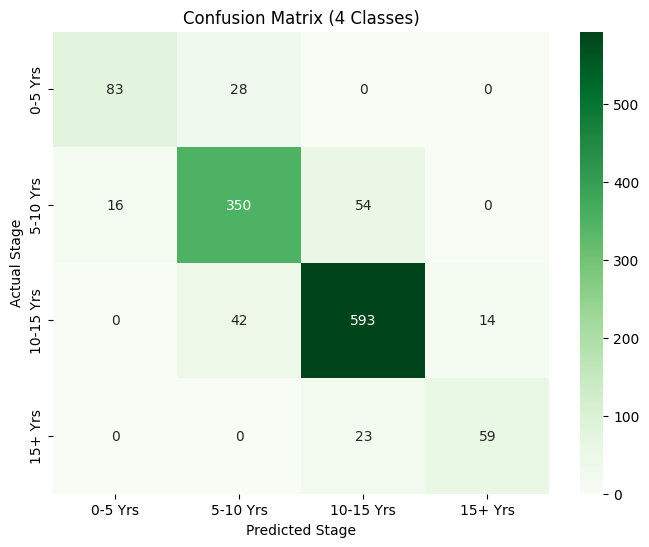

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def run_classification_testing_4class():
    print("\n" + "="*50)
    print("🚀 FINAL EVALUATION: 4-CLASS MODEL")
    print("="*50)

    # 1. SETUP
    base_dir = '/kaggle/input/rsna-bone-age'
    df = pd.read_csv(f'{base_dir}/boneage-training-dataset.csv')
    img_dir = f'{base_dir}/boneage-training-dataset/boneage-training-dataset'

    # Re-split
    _, val_df = train_test_split(df, test_size=0.2, random_state=CONFIG['seed'])
    _, test_df = train_test_split(val_df, test_size=0.5, random_state=CONFIG['seed'])

    test_ds = ClassificationDataset(test_df, img_dir, transform=get_transforms('val'))
    test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

    # 2. LOAD MODEL
    model = BoneAgeClassifier(num_classes=4).to(CONFIG['device']) # Ensure num_classes=4
    checkpoint_path = f"{CONFIG['checkpoint_dir']}/best_4class_model.pth"

    if not os.path.exists(checkpoint_path):
        print("❌ Checkpoint not found.")
        return

    # Load Weights
    state_dict = torch.load(checkpoint_path)
    if 'module.' in list(state_dict.keys())[0]:
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
                new_state_dict[k.replace('module.', '')] = v
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(state_dict)

    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)

    # 3. INFERENCE
    model.eval()
    true_classes, pred_classes = [], []

    print("Processing Test Set...")
    with torch.no_grad():
        for imgs, genders, targets in tqdm(test_loader):
                imgs, genders = imgs.to(CONFIG['device']), genders.to(CONFIG['device'])
                outputs = model(imgs, genders)
                _, preds = torch.max(outputs, 1)
                true_classes.extend(targets.numpy())
                pred_classes.extend(preds.cpu().numpy())

    # 4. REPORT
    class_names = ['0-5 Yrs', '5-10 Yrs', '10-15 Yrs', '15+ Yrs']

    qwk = cohen_kappa_score(true_classes, pred_classes, weights='quadratic')
    print(f'QWK: {qwk:.4f}')

    print("\n" + "-"*40)
    print("📊 CLASSIFICATION REPORT")
    print("-" * 40)
    print(classification_report(true_classes, pred_classes, target_names=class_names))

    # 5. VISUALIZATION
    cm = confusion_matrix(true_classes, pred_classes)
    plt.figure(figsize=(8, 6))


    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Stage')
    plt.ylabel('Actual Stage')
    plt.title('Confusion Matrix (4 Classes)')
    plt.show()


run_classification_testing_4class()


🚀 FINAL GENDER-WISE EVALUATION: 4-CLASS MODEL
Processing Test Set...


  0%|          | 0/40 [00:00<?, ?it/s]


------------------------------------------------------------
📊 GENDER-WISE PERFORMANCE SUMMARY
------------------------------------------------------------
METRIC          | OVERALL    | MALE       | FEMALE    
------------------------------------------------------------
Accuracy        | 0.8597     | 0.8822     | 0.8322
F1 Score        | 0.8587     | 0.8823     | 0.8306
Count           | 1262       | 696        | 566       
------------------------------------------------------------


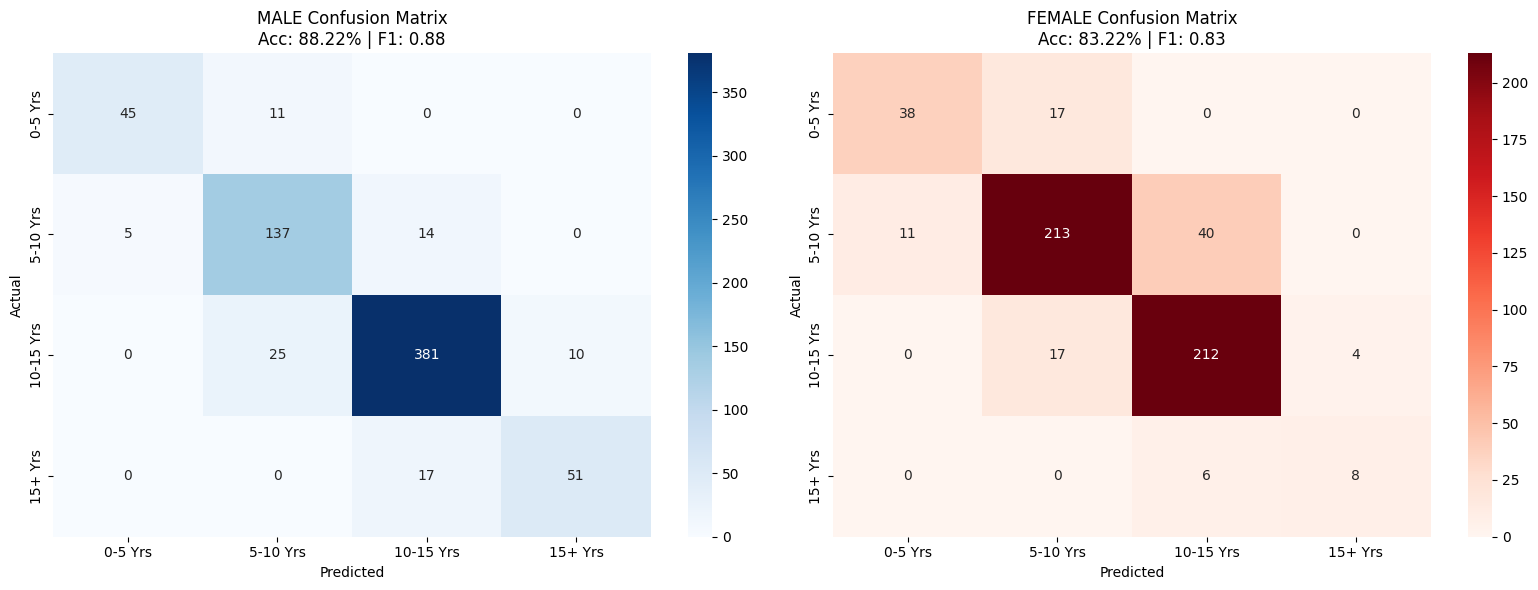


Detailed Report (Male):
              precision    recall  f1-score   support

     0-5 Yrs       0.90      0.80      0.85        56
    5-10 Yrs       0.79      0.88      0.83       156
   10-15 Yrs       0.92      0.92      0.92       416
     15+ Yrs       0.84      0.75      0.79        68

    accuracy                           0.88       696
   macro avg       0.86      0.84      0.85       696
weighted avg       0.88      0.88      0.88       696


Detailed Report (Female):
              precision    recall  f1-score   support

     0-5 Yrs       0.78      0.69      0.73        55
    5-10 Yrs       0.86      0.81      0.83       264
   10-15 Yrs       0.82      0.91      0.86       233
     15+ Yrs       0.67      0.57      0.62        14

    accuracy                           0.83       566
   macro avg       0.78      0.74      0.76       566
weighted avg       0.83      0.83      0.83       566



In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from tqdm.auto import tqdm
import os

def run_classification_testing_4class_gender_wise():
    print("\n" + "="*60)
    print("🚀 FINAL GENDER-WISE EVALUATION: 4-CLASS MODEL")
    print("="*60)

    # 1. SETUP
    base_dir = '/kaggle/input/rsna-bone-age'
    df = pd.read_csv(f'{base_dir}/boneage-training-dataset.csv')
    img_dir = f'{base_dir}/boneage-training-dataset/boneage-training-dataset'
    
    # Re-split to get the exact same test set
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=CONFIG['seed'])
    val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=CONFIG['seed'])
    
    test_ds = ClassificationDataset(test_df, img_dir, transform=get_transforms('val'))
    test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

    # 2. LOAD MODEL
    model = BoneAgeClassifier(num_classes=4).to(CONFIG['device'])
    checkpoint_path = f"{CONFIG['checkpoint_dir']}/best_4class_model.pth"
    
    if not os.path.exists(checkpoint_path):
        print(f"❌ Checkpoint not found at {checkpoint_path}")
        return

    # Load Weights
    state_dict = torch.load(checkpoint_path)
    if 'module.' in list(state_dict.keys())[0]:
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            new_state_dict[k.replace('module.', '')] = v
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(state_dict)

    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)

    # 3. INFERENCE LOOP
    model.eval()
    true_classes = []
    pred_classes = []
    gender_list = [] # Capture gender
    
    print("Processing Test Set...")
    with torch.no_grad():
        for imgs, genders, targets in tqdm(test_loader):
            imgs, genders = imgs.to(CONFIG['device']), genders.to(CONFIG['device'])
            
            outputs = model(imgs, genders)
            _, preds = torch.max(outputs, 1)
            
            true_classes.extend(targets.cpu().numpy())
            pred_classes.extend(preds.cpu().numpy())
            gender_list.extend(genders.cpu().numpy())

    # Convert to arrays
    true_classes = np.array(true_classes)
    pred_classes = np.array(pred_classes)
    gender_arr = np.array(gender_list)
    
    class_names = ['0-5 Yrs', '5-10 Yrs', '10-15 Yrs', '15+ Yrs']

    # ==========================================
    # 4. GENDER-WISE METRICS
    # ==========================================
    male_mask = (gender_arr == 1.0)
    female_mask = (gender_arr == 0.0)

    # -- Overall --
    acc_all = accuracy_score(true_classes, pred_classes)
    f1_all = f1_score(true_classes, pred_classes, average='weighted')
    
    # -- Male --
    m_true = true_classes[male_mask]
    m_pred = pred_classes[male_mask]
    acc_m = accuracy_score(m_true, m_pred)
    f1_m = f1_score(m_true, m_pred, average='weighted')
    
    # -- Female --
    f_true = true_classes[female_mask]
    f_pred = pred_classes[female_mask]
    acc_f = accuracy_score(f_true, f_pred)
    f1_f = f1_score(f_true, f_pred, average='weighted')

    # Print Summary Table
    print("\n" + "-"*60)
    print("📊 GENDER-WISE PERFORMANCE SUMMARY")
    print("-" * 60)
    print(f"{'METRIC':<15} | {'OVERALL':<10} | {'MALE':<10} | {'FEMALE':<10}")
    print("-" * 60)
    print(f"{'Accuracy':<15} | {acc_all:.4f}     | {acc_m:.4f}     | {acc_f:.4f}")
    print(f"{'F1 Score':<15} | {f1_all:.4f}     | {f1_m:.4f}     | {f1_f:.4f}")
    print(f"{'Count':<15} | {len(true_classes):<10} | {len(m_true):<10} | {len(f_true):<10}")
    print("-" * 60)

    # ==========================================
    # 5. VISUALIZATION (Side-by-Side Confusion Matrices)
    # ==========================================
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot Male CM
    cm_m = confusion_matrix(m_true, m_pred)
    


    sns.heatmap(cm_m, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
                xticklabels=class_names, yticklabels=class_names)
    axes[0].set_title(f'MALE Confusion Matrix\nAcc: {acc_m:.2%} | F1: {f1_m:.2f}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Plot Female CM
    cm_f = confusion_matrix(f_true, f_pred)
    sns.heatmap(cm_f, annot=True, fmt='d', cmap='Reds', ax=axes[1], 
                xticklabels=class_names, yticklabels=class_names)
    axes[1].set_title(f'FEMALE Confusion Matrix\nAcc: {acc_f:.2%} | F1: {f1_f:.2f}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Optional: Detailed Text Reports
    print("\nDetailed Report (Male):")
    print(classification_report(m_true, m_pred, target_names=class_names))
    print("\nDetailed Report (Female):")
    print(classification_report(f_true, f_pred, target_names=class_names))

# Run it
run_classification_testing_4class_gender_wise()

# Grad CAM Visualisations

In [53]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, gender, task='regression', class_idx=None):
        """
        task: 'regression' or 'classification'
        class_idx: The class index to visualize (required if task='classification')
        """
        # 1. Forward Pass
        self.model.eval()
        self.model.zero_grad()
        
        # Handle Hybrid vs Single models logic
        outputs = self.model(x, gender)
        
        # Check if output is a tuple (Hybrid) or single tensor (Separate models)
        if isinstance(outputs, tuple):
            reg_out, class_out = outputs
        else:
            # Determine if this single output is regression or classification based on shape
            if outputs.shape[1] == 1:
                reg_out = outputs
                class_out = None
                task = 'regression' # Force regression if model only has 1 output
            else:
                class_out = outputs
                reg_out = None
                task = 'classification'

        # 2. Select Target for Backprop
        if task == 'regression':
            target = reg_out
        elif task == 'classification':
            if class_idx is None:
                # Default to the predicted class if none provided
                class_idx = torch.argmax(class_out, dim=1).item()
            target = class_out[:, class_idx]
            
        # 3. Backward Pass
        target.backward(retain_graph=True)
        
        # 4. Generate Heatmap
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.detach()
        
        # Weight the channels by corresponding gradients
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        # ReLU on top of the heatmap (we only care about positive influence)
        heatmap = F.relu(heatmap)
        
        # Normalize for visualization
        heatmap = heatmap.cpu().numpy()
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)
        
        return heatmap

In [54]:
def visualize_model_features(model, dataloader, device, model_type='hybrid'):
    """
    model_type: 'hybrid', 'regression', or 'classification'
    """
    # 1. Setup GradCAM on the last ResNet layer
    # Note: .module is needed if you used DataParallel, otherwise remove it
    if isinstance(model, torch.nn.DataParallel):
        target_layer = model.module.backbone.layer4[-1]
    else:
        target_layer = model.backbone.layer4[-1]
        
    grad_cam = GradCAM(model, target_layer)
    
    # 2. Get a batch
    images, genders, ages, classes = next(iter(dataloader))
    images, genders = images.to(device), genders.to(device)
    
    # 3. Plotting
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    
    for idx in range(4): # Show 4 examples
        img_tensor = images[idx].unsqueeze(0) # Add batch dim
        gender_tensor = genders[idx].unsqueeze(0)
        
        # -- Original Image --
        # Denormalize for display
        inv_normalize = A.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                    std=[1/0.229, 1/0.224, 1/0.225], always_apply=True)
        img_np = images[idx].cpu().permute(1, 2, 0).numpy()
        # Simple clip for display safety
        img_np = np.clip(img_np * np.array([0.229, 0.224, 0.225]) + 
                         np.array([0.485, 0.456, 0.406]), 0, 1)

        # -- Generate Heatmaps --
        
        # Logic A: If Hybrid, we can generate TWO heatmaps per image
        if model_type == 'hybrid':
            mask_reg = grad_cam(img_tensor, gender_tensor, task='regression')
            mask_cls = grad_cam(img_tensor, gender_tensor, task='classification')
            
            title_mid = "Regression Attention"
            title_right = "Classification Attention"
            heatmap1 = mask_reg
            heatmap2 = mask_cls
            
        # Logic B: Regression Only
        elif model_type == 'regression':
            mask = grad_cam(img_tensor, gender_tensor, task='regression')
            heatmap1 = mask
            heatmap2 = mask # Duplicate or leave blank
            title_mid = "Regression Attention"
            title_right = "(N/A)"

        # Logic C: Classification Only
        elif model_type == 'classification':
            mask = grad_cam(img_tensor, gender_tensor, task='classification')
            heatmap1 = mask
            heatmap2 = mask
            title_mid = "Classification Attention"
            title_right = "(N/A)"

        # Apply colormap
        heatmap1 = cv2.resize(heatmap1, (224, 224))
        heatmap1 = np.uint8(255 * heatmap1)
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
        # Overlay
        overlay1 = heatmap1 * 0.4 + (img_np * 255) * 0.6
        overlay1 = np.clip(overlay1, 0, 255).astype(np.uint8)

        if model_type == 'hybrid':
            heatmap2 = cv2.resize(heatmap2, (224, 224))
            heatmap2 = np.uint8(255 * heatmap2)
            heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
            overlay2 = heatmap2 * 0.4 + (img_np * 255) * 0.6
            overlay2 = np.clip(overlay2, 0, 255).astype(np.uint8)
        else:
            overlay2 = np.zeros_like(overlay1) # Blank

        # Plot
        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title(f"True Age: {ages[idx].item()}m")
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(overlay1)
        axes[idx, 1].set_title(title_mid)
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(overlay2)
        axes[idx, 2].set_title(title_right)
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [55]:
# 1. Loading best model
model.load_state_dict(torch.load('/kaggle/working/checkpoints/best_model.pth'))

# 2. Run visualization
visualize_model_features(model, test_loader, CONFIG['device'], model_type='hybrid') 

NameError: name 'model' is not defined

In [56]:
model.load_state_dict(torch.load('/kaggle/working/checkpoints_regression/best_regression_model.pth'))
visualize_model_features(model, test_loader, CONFIG['device'], model_type='regression') 

NameError: name 'model' is not defined

In [57]:
model.load_state_dict(torch.load('/kaggle/working/checkpoints_classification/best_class_model.pth'))
visualize_model_features(model, test_loader, CONFIG['device'], model_type='classification') 

NameError: name 'model' is not defined